In [ ]:
! pip3 install transformers

     |████████████████████████████████| 4.0 MB 12.2 MB/s 
     |████████████████████████████████| 6.5 MB 22.1 MB/s 
     |████████████████████████████████| 77 kB 5.8 MB/s 
     |████████████████████████████████| 895 kB 39.4 MB/s 
     |████████████████████████████████| 596 kB 51.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import re
import copy
from tqdm.notebook import tqdm
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    classification_report
)

from transformers import (
    AutoTokenizer, 
    AutoModel,
    get_linear_schedule_with_warmup,
    BertModel,
    BertTokenizer,
    BertTokenizerFast
)

In [ ]:
import json
import pandas as pd
import numpy as np
pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
pd.describe_option('max_colwidth')

display.max_colwidth : int or None
    The maximum width in characters of a column in the repr of
    a pandas data structure. When the column overflows, a "..."
    placeholder is embedded in the output. A 'None' value means unlimited.
    [default: 50] [currently: 400]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
citation = pd.DataFrame(columns=['Text_Tokens','Cit_func','citseg_id'])
citation

,Text_Tokens,Cit_func,citseg_id


In [ ]:
import os
paths=[]
#d = "/content/per_func_map_organised_small_11class/all"
d="/content/drive/MyDrive/per_func_map_organised_small_11class/all"
for path in os.listdir(d):
    full_path = os.path.join(d, path)
    if os.path.isfile(full_path):
        paths.append(full_path)

**Reading Data from dataset**

In [ ]:
for i in range(len(paths)):
  path = paths[i]
  print(path)
  f=open(path)
  data=json.load(f)
  for i in data.values():
    citation_contexts=i['citation_contexts']
    for j in range(len(citation_contexts)):
      a=[]
      tokens=citation_contexts[j]['citance']['tokens_pp']
      for cit_refs in range(len(citation_contexts[j]['cit_refs'])):
         citseg_id=citation_contexts[j]['cit_refs'][cit_refs]['citseg_id']
         if citseg_id not in  a:
            a.append(citseg_id)
            c=citation_contexts[j]['cit_refs'][cit_refs]['citseg_id']
            f=citation_contexts[j]['cit_refs'][cit_refs]['function_agreed']
            citation = citation.append({'Text_Tokens':tokens, 'Cit_func':f,'citseg_id':c},ignore_index=True)

/content/drive/MyDrive/per_func_map_organised_small_11class/all/Future.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Support.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Basis.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/CoCoGM.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/CoCoRes.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/CoCoXY.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Motivation.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Neutral.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_small_11class/all/Similar.per_func.map_organised_small.json
/content/drive/MyDrive/per_func_map_organised_sm

**Joining Tokens of text**

In [ ]:
df=citation['Text_Tokens'].tolist()
str1 = [' '.join([str(i) for i in y]) for y in df]
citation['text']=str1

In [ ]:
citation.head()

,Text_Tokens,Cit_func,citseg_id,text
0,"[For, example, ,, it, would, be, helpful, to, consider, strong, correspondence, between, certain, English, and, Chinese, words, ,, as, in, (, CITSEG, ), .]",Future,21,"For example , it would be helpful to consider strong correspondence between certain English and Chinese words , as in ( CITSEG ) ."
1,"[Since, task, initiative, models, contribution, to, domain, /, problemsolving, goals, ,, while, dialogue, initiative, affects, the, cur, -5, An, alternative, strategy, to, step, (, 4, ), is, to, perform, a, database, lookup, based, on, the, ambiguous, query, and, summarize, the, results, (, CITSEG, ), ,, which, we, leave, for, future, work, .]",Future,42,"Since task initiative models contribution to domain / problemsolving goals , while dialogue initiative affects the cur -5 An alternative strategy to step ( 4 ) is to perform a database lookup based on the ambiguous query and summarize the results ( CITSEG ) , which we leave for future work ."
2,"[We, perceive, that, these, results, can, be, extended, to, other, language, models, that, properly, embed, bilexical, context, -, free, grammars, ,, as, for, instance, the, more, general, history, -, based, models, used, in, (, CITSEG, ), and, (, CITSEG, ), .]",Future,34,"We perceive that these results can be extended to other language models that properly embed bilexical context - free grammars , as for instance the more general history - based models used in ( CITSEG ) and ( CITSEG ) ."
3,"[We, perceive, that, these, results, can, be, extended, to, other, language, models, that, properly, embed, bilexical, context, -, free, grammars, ,, as, for, instance, the, more, general, history, -, based, models, used, in, (, CITSEG, ), and, (, CITSEG, ), .]",Future,38,"We perceive that these results can be extended to other language models that properly embed bilexical context - free grammars , as for instance the more general history - based models used in ( CITSEG ) and ( CITSEG ) ."
4,"[We, also, propose, to, consider, aspects, of, reviews, (, CITSEG, ), ,, and, investigate, other, methods, that, measure, class, similarity, ,, such, as, selecting, typical, instances, (, CITSEG, ), .]",Future,9,"We also propose to consider aspects of reviews ( CITSEG ) , and investigate other methods that measure class similarity , such as selecting typical instances ( CITSEG ) ."


**Visualising Citation Function Present**

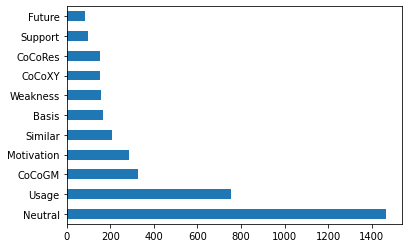

In [ ]:
citation.Cit_func.value_counts().plot(kind='barh')

In [ ]:
display(citation.Cit_func.value_counts())             
print(" ")

Neutral       1463
Usage          755
CoCoGM         328
Motivation     288
Similar        207
Basis          167
Weakness       158
CoCoXY         152
CoCoRes        151
Support        100
Future          85
Name: Cit_func, dtype: int64

**Dropping some rows of Neutral and Usage functions**

In [ ]:
citation.drop(citation.query('Cit_func == "Neutral" ').sample(n=400).index,inplace=True)
citation.drop(citation.query('Cit_func == "Usage" ').sample(n=100).index,inplace=True)

In [ ]:
unique_labels = citation.Cit_func.unique()
unique_labels

array(['Future', 'Support', 'Basis', 'CoCoGM', 'CoCoRes', 'CoCoXY',
       'Neutral', 'Motivation', 'Similar', 'Usage', 'Weakness'],
      dtype=object)

**One- hot encoding for labels**

In [ ]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(unique_labels)

citation['label'] = le.transform(citation.Cit_func)

In [ ]:
#Shuffling the dataframe
citation = citation.sample(frac=1).reset_index(drop=True)

**Splitting the dataset**

In [ ]:
#split the subset by rating to create new train, val and test splits
import collections
by_rating = collections.defaultdict(list)
for _,row in citation.iterrows():
  by_rating[row.Cit_func].append(row.to_dict())

In [ ]:
#create split data
seed =1021
final_list = []
np.random.seed(seed)
train_proportion = 0.7
val_proportion = 0.2
test_proportion = 0.1


for _, item_list in sorted(by_rating.items()):
  np.random.shuffle(item_list)

  n_total = len(item_list)
  n_train = int(train_proportion * n_total)
  n_val = int(val_proportion * n_total)
  n_test = int(test_proportion * n_total)


  #give data points  split attribute

  for item in item_list[:n_train]:
    item['split'] = 'train'

  for item in item_list[n_train:n_train+n_val]:
    item['split'] = 'val'

  for item in item_list[n_train+n_val:n_train+n_val+n_test]:
   item['split'] = 'test'


  #Add to final list

  final_list.extend(item_list)


citation = pd.DataFrame(final_list)

In [ ]:
citation.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split
0,"[To, find, a, smaller, set, of, effective, features, ,, we, start, with, all, the, features, considered, in, (, CITSEG, ), ,, in, (, CITSEG, ), ,, and, various, combinations, of, them, ,, for, a, total, of, 52, features, .]",Basis,18,"To find a smaller set of effective features , we start with all the features considered in ( CITSEG ) , in ( CITSEG ) , and various combinations of them , for a total of 52 features .",0,train
1,"[Before, describing, the, algorithm, ,, it, will, be, helpful, to, have, at, our, disposal, a, few, general, tools, ,, most, of, which, were, described, already, in, CITSEG, .]",Basis,26,"Before describing the algorithm , it will be helpful to have at our disposal a few general tools , most of which were described already in CITSEG .",0,train
2,"[Combining, statistical, and, parsing, methods, has, been, done, by, (, CITSEG, ), and, (, CITSEG, ), .]",Basis,14,Combining statistical and parsing methods has been done by ( CITSEG ) and ( CITSEG ) .,0,train
3,"[Many, methods, have, been, proposed, to, measure, the, co-occurrence, relation, between, two, words, such, as, χ, 2, (, CITSEG, ), ,, mutual, information, (, CITSEG, ), ,, t-test, (, CITSEG, ), ,, and, loglikelihood, (, CITSEG, ), .]",Basis,24,"Many methods have been proposed to measure the co-occurrence relation between two words such as χ 2 ( CITSEG ) , mutual information ( CITSEG ) , t-test ( CITSEG ) , and loglikelihood ( CITSEG ) .",0,train
4,"[It, follows, the, order, model, defined, in, (, CITSEG, ), .]",Basis,8,It follows the order model defined in ( CITSEG ) .,0,train


**Some visualizations after splitting the Dataset**

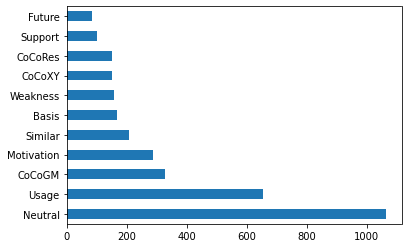

In [ ]:
citation.Cit_func.value_counts().plot(kind='barh')

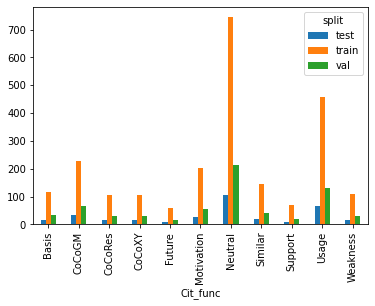

In [ ]:
citation.groupby(['Cit_func','split']).size().unstack(level=1)  
a=citation.groupby(['Cit_func','split']).size().unstack(level=1)  
a.plot(kind='bar')

In [ ]:
citation.groupby(['Cit_func','split']).size()

Cit_func    split
Basis       test      16
            train    116
            val       33
CoCoGM      test      32
            train    229
            val       65
CoCoRes     test      15
            train    105
            val       30
CoCoXY      test      15
            train    106
            val       30
Future      test       8
            train     59
            val       17
Motivation  test      28
            train    201
            val       57
Neutral     test     106
            train    744
            val      212
Similar     test      20
            train    144
            val       41
Support     test      10
            train     70
            val       20
Usage       test      65
            train    458
            val      131
Weakness    test      15
            train    110
            val       31
dtype: int64

**Tokenizer**

In [ ]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizerFast.from_pretrained('/content/drive/MyDrive/scibert_scivocab_uncased')
special_tokens_dict = {'additional_special_tokens': ['CITSEG']}
tokenizer.add_special_tokens(special_tokens_dict=special_tokens_dict)

Loading BERT tokenizer...


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizer'.
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'BertTokenizerFast'.


0

**Splitting the dataset into three datasets: train, val, test**

In [ ]:
df_train = citation[citation.split=='train']
df_val = citation[citation.split=='val']
df_test= citation[citation.split=='test']

print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(2342, 6)
(667, 6)
(330, 6)


**Shuffling the data splits**

In [ ]:
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

**Getting texts and labels**

In [ ]:
sentences_train = df_train.text.values
labels_train = df_train.label.values

sentences_valid = df_val.text.values
labels_valid = df_val.label.values

sentences_test = df_test.text.values
labels_test = df_test.label.values

**Creating input ids, attention masks**

In [ ]:
from keras.preprocessing.sequence import pad_sequences
def create_input_ids_attention_maks(sentences, max_len):
  input_ids = []

  # For every sentence...
  for sent in sentences:
      # `encode` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      encoded_sent = tokenizer.encode(
                          sent,                      
                          add_special_tokens = True,
                          max_length = max_len,         
                          truncation=True
                          
                    )
      
      # Add the encoded sentence to the list.
      input_ids.append(encoded_sent)

  
  # pad the sequences
  input_ids = pad_sequences(input_ids, maxlen=max_len, dtype="long", 
                            value=0, truncating="post", padding="post")
  

  # Create attention masks
  attention_masks = []

  for sent in input_ids:
      
      # Create the attention mask.
      #   - If a token ID is 0, then it's padding, set the mask to 0.
      #   - If a token ID is > 0, then it's a real token, set the mask to 1.
      att_mask = [int(token_id > 0) for token_id in sent]
      
      attention_masks.append(att_mask)

  return [input_ids, attention_masks]

In [ ]:
input_ids_train, attention_masks_train = create_input_ids_attention_maks(sentences_train, 200)
input_ids_valid, attention_masks_valid = create_input_ids_attention_maks(sentences_valid, 200)
input_ids_test, attention_masks_test = create_input_ids_attention_maks(sentences_test, 200)

In [ ]:
input_ids_train.shape

(2342, 200)

**Calculating position of Citseg in tokenised text**

In [ ]:
def calc_tok_cit_seg_id(df,input_id):
  cit_id=df['citseg_id'].values
  k=0
  tok_cid=[]
  for i in input_id:
    cit_seg_tok_id=-1
    #print(i)
    for j in i:
      #print(j)

      cit_seg_tok_id +=1
      if (j==1 and cit_seg_tok_id>= cit_id[k]):
        if(cit_seg_tok_id!= None):
          #print("cit_seg_tok_id for ", k ,"is: ", cit_seg_tok_id)
          tok_cid.append(cit_seg_tok_id)
          #print(k,len(tok_cid))
        else:
          print("no citseg")
        break
    k+=1
  #print(k)
  return tok_cid

In [ ]:
id_train= calc_tok_cit_seg_id(df_train,input_ids_train)
id_val= calc_tok_cit_seg_id(df_val,input_ids_valid) 
id_test= calc_tok_cit_seg_id(df_test,input_ids_test)

In [ ]:
len(id_train)

2342

**Adding Citseg position to Dataframes**

In [ ]:
df_train.loc[:,'tok_citseg_id']=id_train
df_test['tok_citseg_id']=id_test
df_val.loc[:,'tok_citseg_id']=id_val

In [ ]:
df_train.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split,tok_citseg_id
0,"[The, ACL, Anthology, Network, (, AAN, ), 2, is, a, collection, of, papers, from, the, ACL, Anthology, 3, published, in, the, Computational, Linguistics, journal, and, proceedings, from, ACL, conferences, and, workshops, and, includes, more, than, 14, ,, 000, papers, over, a, period, of, four, decades, (, CITSEG, ), .]",Neutral,46,"The ACL Anthology Network ( AAN ) 2 is a collection of papers from the ACL Anthology 3 published in the Computational Linguistics journal and proceedings from ACL conferences and workshops and includes more than 14 , 000 papers over a period of four decades ( CITSEG ) .",6,train,50
1,"[Initiatives, such, as, PropBank, (, PB, ), (, CITSEG, ), have, made, possible, the, design, of, accurate, automatic, Semantic, Role, Labeling, (, SRL, ), systems, like, ASSERT, (, CITSEG, ), In, order, to, calculate, the, semantic, similarity, between, the, sentences, ,, we, first, represent, the, annotated, sentence, using, the, tree, structures, like, Figure, 1, which, we, call, Semantic, T...",Neutral,8,"Initiatives such as PropBank ( PB ) ( CITSEG ) have made possible the design of accurate automatic Semantic Role Labeling ( SRL ) systems like ASSERT ( CITSEG ) In order to calculate the semantic similarity between the sentences , we first represent the annotated sentence using the tree structures like Figure 1 which we call Semantic Tree ( ST ) .",6,train,10
2,"[Work, in, this, area, is, largely, motivated, by, the, topic, detection, and, tracking, (, TDT, ), initiative, (, CITSEG, ), .]",Neutral,18,Work in this area is largely motivated by the topic detection and tracking ( TDT ) initiative ( CITSEG ) .,6,train,20
3,"[This, would, be, the, case, in, query, expansion, for, information, retrieval, ,, for, example, ,, where, indiscriminately, adding, inappropriate, words, to, a, query, can, degrade, performance, (, CITSEG, ), .]",Neutral,27,"This would be the case in query expansion for information retrieval , for example , where indiscriminately adding inappropriate words to a query can degrade performance ( CITSEG ) .",6,train,31
4,"[We, now, have, two, probability, distributions, that, we, need, to, estimate, ,, which, we, do, using, decision, trees, (, CITSEG, ), .]",Usage,19,"We now have two probability distributions that we need to estimate , which we do using decision trees ( CITSEG ) .",9,train,20


In [ ]:
df_val.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split,tok_citseg_id
0,"[The, following, sections, discuss, related, work, ,, describe, the, learning, procedure, and, evaluate, it, on, the, Brown, Corpus, (, CITSEG, ), .]",Usage,19,"The following sections discuss related work , describe the learning procedure and evaluate it on the Brown Corpus ( CITSEG ) .",9,val,20
1,"[Group, 11, uses, 2, lists, of, 1636, positive, and, 2008, negative, words, ,, obtained, from, (, CITSEG, ), .]",Usage,16,"Group 11 uses 2 lists of 1636 positive and 2008 negative words , obtained from ( CITSEG ) .",9,val,18
2,"["", Comprehension, -, based, summarization, ,, e.g., CITSEG, ,, is, the, most, ambitious, model, of, automatic, summarization, ,, requiring, a, complete, understanding, of, the, text, .]",Neutral,7,""" Comprehension - based summarization , e.g. CITSEG , is the most ambitious model of automatic summarization , requiring a complete understanding of the text .",6,val,12
3,"[Eighteen, baseline, features, and, six, additional, features, are, proposed, in, (, CITSEG, ), for, Nom, -Bank, argument, identification, .]",Usage,11,Eighteen baseline features and six additional features are proposed in ( CITSEG ) for Nom -Bank argument identification .,9,val,12
4,"[Other, researchers, have, considered, particular, aspects, of, the, problem, such, as, accounting, for, various, aspects, of, actions, (, CITSEG, ), .]",Neutral,18,Other researchers have considered particular aspects of the problem such as accounting for various aspects of actions ( CITSEG ) .,6,val,19


In [ ]:
df_test.head()

,Text_Tokens,Cit_func,citseg_id,text,label,split,tok_citseg_id
0,"[Discourse, markers, (, CITSEG, ), are, used, to, relate, new, speech, to, the, current, discourse, state, .]",Neutral,3,Discourse markers ( CITSEG ) are used to relate new speech to the current discourse state .,6,test,4
1,"[There, are, many, different, criteria, for, quantifying, the, (, dis, ), similarity, between, (, analyses, of, ), two, sentences, or, between, two, clusters, of, sentences, ;, CITSEG, provides, a, good, overview, .]",Neutral,26,There are many different criteria for quantifying the ( dis ) similarity between ( analyses of ) two sentences or between two clusters of sentences ; CITSEG provides a good overview .,6,test,27
2,"[Features, were, discovered, from, the, actual, sentence, plan, trees, that, the, SPG, generated, through, the, feature, derivation, process, described, below, ,, in, a, manner, similar, to, that, used, by, CITSEG, .]",Usage,29,"Features were discovered from the actual sentence plan trees that the SPG generated through the feature derivation process described below , in a manner similar to that used by CITSEG .",9,test,31
3,"[On, the, basis, of, the, usefulness, of, probabilistic, context, -, free, grammars, (, CITSEG, ,, ch., 5, ), ,, it, is, plausible, to, assume, that, that, the, extension, of, probabilistic, techniques, to, such, structures, will, allow, the, application, of, known, and, new, techniques, of, parse, ranking, and, grammar, induction, to, more, interesting, grammars, than, has, hitherto, been, th...",Neutral,13,"On the basis of the usefulness of probabilistic context - free grammars ( CITSEG , ch. 5 ) , it is plausible to assume that that the extension of probabilistic techniques to such structures will allow the application of known and new techniques of parse ranking and grammar induction to more interesting grammars than has hitherto been the case .",6,test,14
4,"[CITSEG, reported, an, intra-subject, correlation, of, r=.85, for, 15, subjects, judging, the, similarity, of, a, subset, (, 36, ), of, the, original, 65, word, pairs, .]",CoCoRes,0,CITSEG reported an intra-subject correlation of r=.85 for 15 subjects judging the similarity of a subset ( 36 ) of the original 65 word pairs .,2,test,1


**Create torch tensors required for DataLoader**

In [ ]:

train_inputs = torch.tensor(input_ids_train)
validation_inputs = torch.tensor(input_ids_valid)
citseg_train_inputs=torch.tensor(id_train)
test_inputs = torch.tensor(input_ids_test)


train_labels = torch.tensor(df_train.label.values)
validation_labels = torch.tensor(df_val.label.values)
citseg_validation_inputs=torch.tensor(id_val)
test_labels = torch.tensor(df_test.label.values)

train_masks = torch.tensor(attention_masks_train)
validation_masks = torch.tensor(attention_masks_valid)
citseg_test_inputs=torch.tensor(id_test)
test_masks = torch.tensor(attention_masks_test)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn as nn

batch_size = 16


# DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels,citseg_train_inputs)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels,citseg_validation_inputs)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels,citseg_test_inputs)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [ ]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')

**Custom SciBert Model**

In [ ]:
#Create custom scibert model for sequence classification
class CustomSciBERTModel(nn.Module):
    def __init__(self):
      super(CustomSciBERTModel, self).__init__()
      self.scibert = BertModel.from_pretrained('/content/drive/MyDrive/scibert_scivocab_uncased')
      self.num_labels = 11
      self.dropout = nn.Dropout(0.3)
      self.linear_layer = nn.Linear(768, 11)
     

    def forward(self, ids, mask, labels,citseg_id):
      output = self.scibert(
            input_ids=ids, 
            attention_mask=mask)
      last_hidden_states = output[0]
      
      #gather function
      batch_size,columns=ids.shape
      citseg_id = citseg_id.view(batch_size,1,1)
      citseg_id = citseg_id.repeat(1,1,768)
      pooled_states2 = torch.gather(input=last_hidden_states, dim=1, index=citseg_id)
      #print("pooled_states2:", pooled_states2)
      citseg_feature_vector = torch.squeeze(pooled_states2, dim=1)


      #logits = self.dropout(output[1])
      #logits = self.linear_layer(logits[1])
      logits = self.linear_layer(citseg_feature_vector) 

      loss = None
      # while training return loss and while validation/ testing resturn logits
      if labels is not None:
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return loss
      else:
        return logits

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

# Create model object
model = CustomSciBERTModel()

# Get model on to GPU
model.cuda()

# Optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# Number of epochs
epochs = 20

# training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value 
                                            num_training_steps = total_steps)

Some weights of the model checkpoint at /content/drive/MyDrive/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is depre

In [ ]:
# Compute accuracy
def accuracy(preds, labels):
    pred = np.argmax(preds, axis=1).flatten()
    labels = labels.flatten()
    return np.sum(pred == labels) / len(labels)

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [ ]:
def macroscore(preds,labels):
  pred = np.argmax(preds, axis=1).flatten()
  labels = labels.flatten()
  val_macro_f1_score = f1_score(labels, pred, average='macro')
  return val_macro_f1_score 

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

true, pred = [], []

predictions=[]
prediction=[]
y=[]

# Store the average loss after each epoch so we can plot them.
training_loss_values = []
validation_loss_values= []

# set initial loss to infinite
best_valid_loss = float('inf')

# store predictions on validation data
valid_preds = []

max_val_f1_score=0

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains four pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        #   [3]: citseg ids 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_citseg_id=batch[3].to(device)
        

        # backward pass. PyTorch doesn't do this automatically because 
        model.zero_grad()        

        # Forward pass
        outputs = model(ids = b_input_ids, mask = b_input_mask, labels = b_labels, citseg_id=b_citseg_id)
        
        # forward pass gives loss as output
        loss = outputs

        # accumulate loss
        total_loss += loss.item()

        # backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0. to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    training_loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Reset the total validation loss for this epoch.
    total_valid_loss = 0

    # evaluation mode.
    model.eval()

    # evaluation loss and accuracy
    eval_loss, eval_accuracy = 0, 0
    running_loss, running_acc= 0 , 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels,b_citseg_id = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # It gives logits when labels are not given to model
            outputs = model(b_input_ids, 
                            b_input_mask, labels = None, citseg_id=b_citseg_id)
        
        # Get the "logits" output by the model. The "logits" are the output
        logits = outputs

        # Track the number of batches
        nb_eval_steps += 1

        # compute the loss
        loss_fct = nn.CrossEntropyLoss()
        loss = loss_fct(logits, b_labels)
        loss_t = loss.item()
        running_loss += (loss_t - running_loss) / (nb_eval_steps)    

        # Calculate the average loss over the validating data.
        # accumulate loss
        total_valid_loss += loss.item()
        avg_valid_loss = total_valid_loss / len(validation_dataloader)
         
         #save the best model
        if avg_valid_loss < best_valid_loss:
          best_valid_loss = avg_valid_loss
          torch.save(model.state_dict(), 'saved_weights.pt') 

        

        #appending predictions and true labels for last epoch
        if(epoch_i==epochs-1):
          _, predictions = logits.max(dim=1)
          prediction.append(predictions)
          y.append(b_labels)

        #compute the accuracy
        acc_t = compute_accuracy(logits, b_labels)
        running_acc += (acc_t - running_acc) / (nb_eval_steps)


        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        valid_preds.extend(np.argmax(logits, axis=1).flatten())
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        #calculate macro f1 score
        val_f1_score=macroscore(logits, label_ids)

        if val_f1_score>max_val_f1_score:
          max_val_f1_score=val_f1_score

        

    # Store the loss value for plotting the learning curve.
    validation_loss_values.append(avg_valid_loss)
    
    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Average Validation loss: {0:.2f}".format(avg_valid_loss))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))
    print("The Val macro f1 score is: ", max_val_f1_score)
    print('Epoch {}\t val_loss={}\t val_acc={}'.format(epoch_i, running_loss, running_acc))
      
    

print("")
print("Training complete!")


======== Epoch 1 / 20 ========
Training...
  Batch    40  of    147.    Elapsed: 0:00:15.
  Batch    80  of    147.    Elapsed: 0:00:28.
  Batch   120  of    147.    Elapsed: 0:00:41.

  Average training loss: 1.69
  Training epcoh took: 0:00:50

Running Validation...
  Accuracy: 0.57
  Average Validation loss: 1.37
  Validation took: 0:00:06
The Val macro f1 score is:  0.6055555555555555
Epoch 0	 val_loss=1.367465311572665	 val_acc=56.872294372294384

======== Epoch 2 / 20 ========
Training...
  Batch    40  of    147.    Elapsed: 0:00:13.
  Batch    80  of    147.    Elapsed: 0:00:27.
  Batch   120  of    147.    Elapsed: 0:00:40.

  Average training loss: 1.01
  Training epcoh took: 0:00:49

Running Validation...
  Accuracy: 0.61
  Average Validation loss: 1.25
  Validation took: 0:00:05
The Val macro f1 score is:  0.7354166666666666
Epoch 1	 val_loss=1.2501676919914426	 val_acc=61.48538961038961

======== Epoch 3 / 20 ========
Training...
  Batch    40  of    147.    Elapsed: 0:00

In [ ]:
training_loss_values 

[1.6916211993515897,
 1.0084449044701194,
 0.5729073450273398,
 0.29872200404908383,
 0.17035703660071302,
 0.07915571575262109,
 0.04597503208906903,
 0.027304409167429964,
 0.012668640098968509,
 0.012270203588821856,
 0.009693829259371105,
 0.007402379348078984,
 0.009069135927038464,
 0.005749681220191125,
 0.006952781434927997,
 0.004748241939771205,
 0.004569918654944596,
 0.004975452336093068,
 0.003903406373568459,
 0.0028625574545696423]

In [ ]:
validation_loss_values

[1.3674653115726652,
 1.2501676919914426,
 1.3918159731796809,
 1.581176641441527,
 1.6956295768419902,
 1.8900910743645258,
 2.1957426979428245,
 2.3283845541023074,
 2.3877435411725725,
 2.500019703592573,
 2.4759401494548436,
 2.5713693641480946,
 2.591145775147847,
 2.5879423845381964,
 2.6345231660774777,
 2.6290326643557775,
 2.632584865604128,
 2.635891529775801,
 2.6589130617323375,
 2.663451400541124]

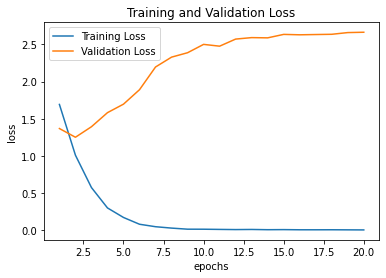

In [ ]:
import matplotlib.pyplot as plt
# line 1 points
x1 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
y1 = training_loss_values
# plotting the line 1 points 
plt.plot(x1, y1, label = "Training Loss")
# line 2 points

y2 = validation_loss_values
# plotting the line 2 points 
plt.plot(x1, y2, label = "Validation Loss")
plt.xlabel('epochs')
# Set the y axis label of the current axis.
plt.ylabel('loss')
# Set a title of the current axes.
plt.title('Training and Validation Loss')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [ ]:
y.pop()

tensor([10,  9,  9,  6,  5,  9,  6,  9,  1, 10,  9], device='cuda:0')

In [ ]:
prediction.pop()

tensor([5, 9, 9, 6, 5, 5, 7, 9, 1, 5, 9], device='cuda:0')

In [ ]:
y_tensor = torch.stack(y)
pred_tensor = torch.stack(prediction)

In [ ]:
true_y=y_tensor.cpu().detach().numpy()
pred_y=pred_tensor.cpu().detach().numpy()

In [ ]:
true_y.shape

(41, 16)

In [ ]:
pred_y=pred_y.flatten()

In [ ]:
true_y=true_y.flatten()

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Basis","CoCoGM", "CoCoRes", "CoCoXY","Future","Motivation","Neutral","Similar","Support","Usage","Weakness"]
#'Future', 'Support', 'Basis', 'CoCoGM', 'CoCoRes', 'CoCoXY','Neutral', 'Motivation', 'Similar', 'Usage', 'Weakness'
print(classification_report(true_y, pred_y, target_names=target_names))


              precision    recall  f1-score   support

       Basis       0.41      0.42      0.42        33
      CoCoGM       0.56      0.59      0.58        64
     CoCoRes       0.75      0.60      0.67        30
      CoCoXY       0.50      0.30      0.37        30
      Future       0.65      0.65      0.65        17
  Motivation       0.59      0.61      0.60        56
     Neutral       0.69      0.70      0.70       210
     Similar       0.63      0.59      0.61        41
     Support       0.36      0.40      0.38        20
       Usage       0.63      0.67      0.65       126
    Weakness       0.41      0.41      0.41        29

    accuracy                           0.61       656
   macro avg       0.56      0.54      0.55       656
weighted avg       0.61      0.61      0.61       656



In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_y, pred_y)

In [ ]:
cf_matrix

array([[ 14,   1,   0,   0,   0,   1,   6,   0,   0,  11,   0],
       [  3,  38,   0,   2,   0,   3,   9,   4,   1,   2,   2],
       [  0,   3,  18,   0,   0,   0,   2,   2,   0,   3,   2],
       [  0,   4,   2,   9,   0,   3,   6,   3,   0,   2,   1],
       [  0,   0,   2,   0,  11,   0,   2,   0,   1,   1,   0],
       [  1,   2,   1,   0,   0,  34,  11,   0,   2,   1,   4],
       [  3,   6,   0,   4,   3,  10, 148,   1,   6,  21,   8],
       [  1,   6,   0,   0,   0,   0,   6,  24,   0,   4,   0],
       [  1,   0,   0,   0,   1,   4,   4,   0,   8,   2,   0],
       [ 10,   5,   1,   0,   2,   2,  13,   4,   4,  85,   0],
       [  1,   3,   0,   3,   0,   1,   7,   0,   0,   2,  12]])

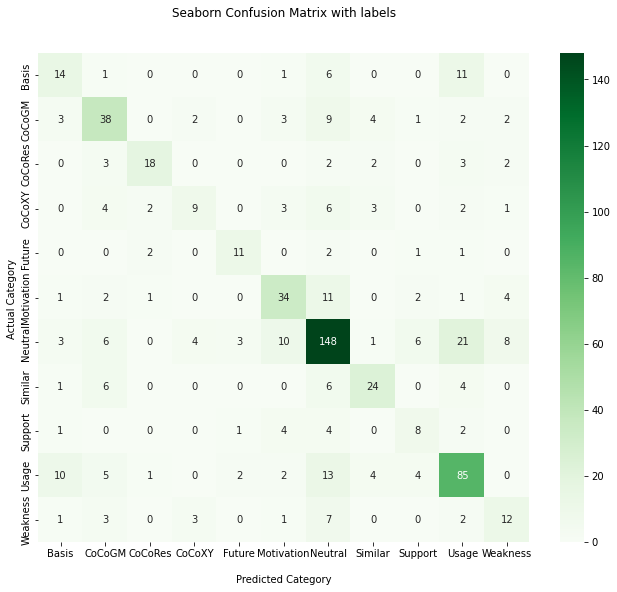

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(11, 9))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');


## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Basis","CoCoGM", "CoCoRes", "CoCoXY","Future","Motivation","Neutral","Similar","Support","Usage","Weakness"])
ax.yaxis.set_ticklabels(["Basis","CoCoGM", "CoCoRes", "CoCoXY","Future","Motivation","Neutral","Similar","Support","Usage","Weakness"])

## Display the visualization of the Confusion Matrix.
plt.show()

**Testing**

In [ ]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
tot_pred=[]
tot_labels=[]
input_ids=[]

for batch in test_dataloader:
        
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_citseg_id = batch
    
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up validation
    with torch.no_grad():        

        # It gives logits when labels are not given to model
        outputs = model(b_input_ids, 
                        b_input_mask, labels = None, citseg_id=b_citseg_id)
    
    # Get the "logits" output by the model. The "logits" are the output
    #logits = outputs
    _, logits = outputs.max(dim=1)
    tot_pred.append(logits)
    tot_labels.append(b_labels)
    input_ids.append(b_input_ids)

In [ ]:
tot_labels.pop()

tensor([2, 6, 8, 3, 9, 9, 9, 1, 6, 6], device='cuda:0')

In [ ]:
tot_pred.pop()

tensor([6, 9, 6, 6, 9, 9, 6, 1, 6, 6], device='cuda:0')

In [ ]:
input_ids.pop()

tensor([[ 102,  259, 1031,  ...,    0,    0,    0],
        [ 102,  121,  407,  ...,    0,    0,    0],
        [ 102, 2602,  579,  ...,    0,    0,    0],
        ...,
        [ 102,  494, 2688,  ...,    0,    0,    0],
        [ 102,  121,  145,  ...,    0,    0,    0],
        [ 102, 1558, 2357,  ...,    0,    0,    0]], device='cuda:0')

In [ ]:
tot_labels_tensor = torch.stack(tot_labels)
tot_pred_tensor = torch.stack(tot_pred)
input_ids_tensor=torch.stack(input_ids)

In [ ]:
true_y=tot_labels_tensor.cpu().detach().numpy()
pred_y=tot_pred_tensor.cpu().detach().numpy()
input_id=input_ids_tensor.cpu().detach().numpy()

In [ ]:
sent=[]
for i in (input_ids_tensor):
  for j in i:
    x=tokenizer.convert_ids_to_tokens(j)
    #print(x)
    sent.append(x)

In [ ]:
true_y.shape

(20, 16)

In [ ]:
pred_y=pred_y.flatten()

In [ ]:
true_y=true_y.flatten()

In [ ]:
from sklearn.metrics import classification_report
target_names = ["Basis","CoCoGM", "CoCoRes", "CoCoXY","Future","Motivation","Neutral","Similar","Support","Usage","Weakness"]
#target_names = ["Future","Neut","PSim","compare_contrast","support"]
print(classification_report(true_y, pred_y, target_names=target_names))

              precision    recall  f1-score   support

       Basis       1.00      0.12      0.22        16
      CoCoGM       0.33      0.45      0.38        31
     CoCoRes       0.80      0.29      0.42        14
      CoCoXY       0.29      0.14      0.19        14
      Future       0.00      0.00      0.00         8
  Motivation       0.68      0.46      0.55        28
     Neutral       0.54      0.85      0.66       103
     Similar       0.56      0.45      0.50        20
     Support       0.50      0.11      0.18         9
       Usage       0.76      0.66      0.71        62
    Weakness       0.50      0.33      0.40        15

    accuracy                           0.56       320
   macro avg       0.54      0.35      0.38       320
weighted avg       0.58      0.56      0.53       320



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

#Generate the confusion matrix
cf_matrix = confusion_matrix(true_y, pred_y)

In [ ]:
cf_matrix

array([[ 2,  4,  0,  0,  0,  0,  4,  1,  1,  4,  0],
       [ 0, 14,  0,  1,  0,  0, 13,  1,  0,  1,  1],
       [ 0,  3,  4,  3,  0,  0,  3,  1,  0,  0,  0],
       [ 0,  3,  0,  2,  0,  1,  6,  1,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  6,  1,  0,  1,  0],
       [ 0,  2,  0,  0,  0, 13, 12,  0,  0,  1,  0],
       [ 0,  4,  0,  0,  0,  4, 88,  0,  0,  4,  3],
       [ 0,  7,  0,  0,  0,  0,  3,  9,  0,  1,  0],
       [ 0,  2,  0,  0,  0,  1,  4,  0,  1,  1,  0],
       [ 0,  2,  1,  1,  0,  0, 15,  2,  0, 41,  0],
       [ 0,  1,  0,  0,  0,  0,  9,  0,  0,  0,  5]])

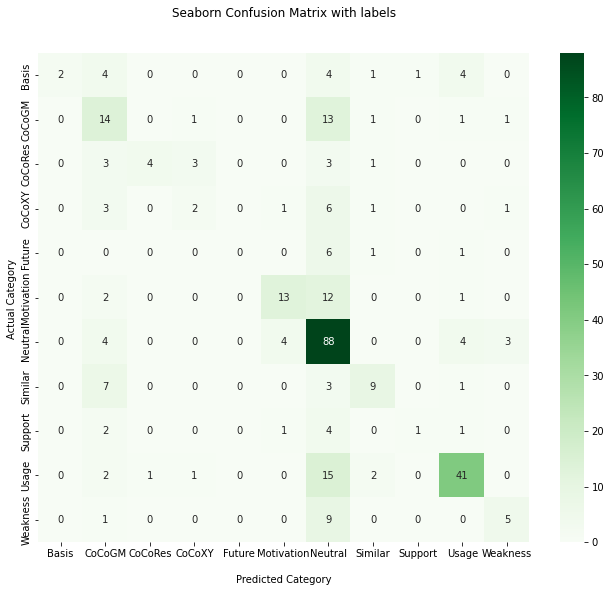

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(11, 9))
ax = sns.heatmap(cf_matrix, annot=True, cmap='Greens',fmt="d")

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Category')
ax.set_ylabel('Actual Category ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(["Basis","CoCoGM", "CoCoRes", "CoCoXY","Future","Motivation","Neutral","Similar","Support","Usage","Weakness"])
ax.yaxis.set_ticklabels(["Basis","CoCoGM", "CoCoRes", "CoCoXY","Future","Motivation","Neutral","Similar","Support","Usage","Weakness"])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
df=pd.DataFrame()
df['Actual Label']= true_y
df['Tokenised Text']=sent
df['predictions']= pred_y

In [ ]:
df['predictions'].replace({0: "Basis",1: "CoCoGM",2:  "CoCoRes", 3:"CoCoXY", 4: "Future", 5: "Motivation", 6: "Neutral", 7:"Similar", 8:"Support",9: "Usage", 10:"Weakness"}, inplace=True)
df['Actual Label'].replace({0: "Basis",1: "CoCoGM",2:  "CoCoRes", 3:"CoCoXY", 4: "Future", 5: "Motivation", 6: "Neutral", 7:"Similar", 8:"Support",9: "Usage", 10:"Weakness"}, inplace=True)

In [ ]:
df

,Actual Label,Tokenised Text,predictions
0,Neutral,"[[CLS], discourse, markers, (, CITSEG, ), are, used, to, relate, new, speech, to, the, current, discourse, state, ., [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD],...",Neutral
1,Neutral,"[[CLS], there, are, many, different, criteria, for, quantifying, the, (, dis, ), similarity, between, (, analyses, of, ), two, sentences, or, between, two, clusters, of, sentences, ;, CITSEG, provides, a, good, overview, ., [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD...",Neutral
2,Usage,"[[CLS], features, were, discovered, from, the, actual, sentence, plan, trees, that, the, sp, ##g, generated, through, the, feature, derivation, process, described, below, ,, in, a, manner, similar, to, that, used, by, CITSEG, ., [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD],...",Similar
3,Neutral,"[[CLS], on, the, basis, of, the, usefulness, of, probabilistic, context, -, free, grammars, (, CITSEG, ,, ch, ., 5, ), ,, it, is, plausible, to, assume, that, that, the, extension, of, probabilistic, techniques, to, such, structures, will, allow, the, application, of, known, and, new, techniques, of, parse, ranking, and, grammar, induction, to, more, interesting, grammars, than, has, hit, ##he...",Neutral
4,CoCoRes,"[[CLS], CITSEG, reported, an, intra, -, subject, correlation, of, r, =, ., 85, for, 15, subjects, judg, ##ing, the, similarity, of, a, subset, (, 36, ), of, the, original, 65, word, pairs, ., [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [...",Neutral
5,Weakness,"[[CLS], though, several, studies, with, similar, objectives, have, been, reported, [, CITSEG, ], ,, [, CITSEG, ], ,, [, CITSEG, ], ,, [, CITSEG, ], ,, [, CITSEG, ], ,, [, CITSEG, ], ,, they, require, that, sample, corpora, be, correctly, analyzed, or, tagged, in, advance, ., [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [...",Weakness
6,Neutral,"[[CLS], CITSEG, confirmed, these, preferences, when, testing, their, ideas, on, the, brown, corpus, ., [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD],...",Neutral
7,Neutral,"[[CLS], the, interest, in, the, 80, ', s, begun, to, turn, considering, grammar, checking, as, an, enterprise, of, its, own, right, (, CITSEG, ), ,, (, CITSEG, ), ,, (, CITSEG, ), ,, (, CITSEG, ), ,, though, many, of, the, approaches, were, still, in, i, ;, t, ##1, (, :, nl, ##u, tradition, (, CITSEG, ), ,, (, CITSEG, ), ,, (, CITSEG, ), ,, (, CITSEG, ), ,, (, CITSEG, ), ., [SEP], [PAD], [PAD]...",Weakness
8,Usage,"[[CLS], following, walker, ', s, weak, ##est, link, assumption, (, CITSEG, ), the, strength, of, the, evidence, is, the, weaker, of, the, strength, of, the, belief, and, the, strength, of, the, evident, ##ial, relationship, ., [SEP], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [PAD], [...",Usage
9,Neutral,"[[CLS], this, includes, both, the, parser, ##s, that, attach, probabilities, to, parser, moves, (, CITSEG, ), ,, but, also, those, of, the, lexical, ##ized, pc, ##fg, vari